In [1]:
import sys
 
# setting path
sys.path.append('../')
import csv

from utils.dataloaders import MIDIEvalDataLoader
from utils.display import display_dicom
from dcm_anonymizers.utils import list_all_files

from pathlib import Path

In [2]:
root_data_dir = '/home/r079a/Desktop/de-identification/dataset'

loader = MIDIEvalDataLoader(
    rawimagespath=Path(root_data_dir, 'images/manifest-1617826555824'),
    deidimagespath=Path(root_data_dir, 'images-2/manifest-1617826161202'),
    uidsmappath=Path(root_data_dir, 'Pseudo-PHI-DICOM-Dataset-uid_crosswalk.csv'),
)

In [3]:
(rawdcm, metadata), (deiddcm, deiddcm_metadata) = loader.get_raw_n_deid_patient(8, include_metadata=True)

{'Series UID': '2.25.266330404550956556941727606810649148918', 'Collection': 'Pseudo-PHI-DICOM-Data', '3rd Party Analysis': 'NO', 'Data Description URI': 'https://doi.org/10.7937/s17zr072', 'Subject ID': 6451050561, 'Study UID': '2.25.332499716250305887681441969149281156598', 'Study Description': nan, 'Study Date': '07-28-1961', 'Series Description': 'PET IR CTAC WB', 'Manufacturer': 'GE MEDICAL SYSTEMS', 'Modality': 'PT', 'SOP Class Name': 'Positron Emission Tomography Image Storage', 'SOP Class UID': '1.2.840.10008.5.1.4.1.1.128', 'Number of Images': 175, 'File Size': '6.69 MB', 'File Location': './Pseudo-PHI-DICOM-Data/6451050561/07-28-1961-NA-NA-56598/PET IR CTAC WB-48918', 'Download Timestamp': '2024-06-03T18:21:12.666'}


In [4]:
deiddcm_metadata

{'Series UID': '1.3.6.1.4.1.14519.5.2.1.8700.9668.247682086785082569558263857709',
 'Collection': 'Pseudo-PHI-DICOM-Data',
 '3rd Party Analysis': 'NO',
 'Data Description URI': 'https://doi.org/10.7937/s17zr072',
 'Subject ID': 'Pseudo-PHI-008',
 'Study UID': '1.3.6.1.4.1.14519.5.2.1.8700.9668.178510714460248717553766553500',
 'Study Description': nan,
 'Study Date': '07-11-1951',
 'Series Description': 'PET IR CTAC WB',
 'Manufacturer': 'GE MEDICAL SYSTEMS',
 'Modality': 'PT',
 'SOP Class Name': 'Positron Emission Tomography Image Storage',
 'SOP Class UID': '1.2.840.10008.5.1.4.1.1.128',
 'Number of Images': 175,
 'File Size': '6.81 MB',
 'File Location': './Pseudo-PHI-DICOM-Data/Pseudo-PHI-008/07-11-1951-NA-NA-53500/PET IR CTAC WB-57709',
 'Download Timestamp': '2024-06-03T18:25:41.214'}

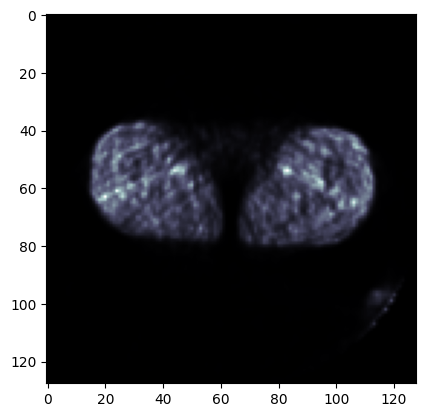

In [5]:
display_dicom(rawdcm[0])

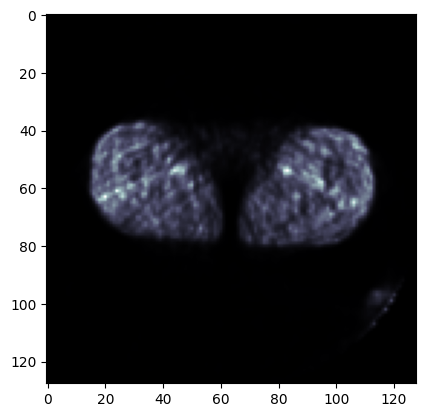

In [6]:
display_dicom(deiddcm[0])

In [7]:
# for element in rawdcm[0]:
#     if element.VR == 'OW' or element.VR == 'UI':
#         continue
        
#     thisval = element.value
#     deidval = ''
#     if element.tag in deiddcm[0]:
#         deidval = deiddcm[0][element.tag].value

#     if deidval != thisval:
#         print(element.tag, element.name, element.VR)
#         print(f"{thisval} --> {deidval}")

In [8]:
from dicomanonymizer.anonymizer import anonymize
from pathlib import Path
import os

In [9]:
rootdir = '/home/r079a/Desktop/de-identification/'

raw_img_path = Path(rootdir, 'dataset/images/manifest-1617826555824', metadata['File Location'])
output_path = Path(rootdir, 'dicom-output')

In [10]:
first_dcm_name = os.listdir(raw_img_path)[0]
first_dcm_name

'1-001.dcm'

In [11]:
anonymize(
    Path(raw_img_path, first_dcm_name), output_path, {}, True,
)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 40.04it/s]


In [12]:
from pydicom import dcmread
import pandas as pd

In [13]:
with open(Path(output_path, first_dcm_name), 'rb') as infile:
    ds = dcmread(infile)

In [14]:
tagvalues = []
for element in rawdcm[0]:
    if element.VR == 'OW':
        continue
    deidval = "Not available"
    if element.tag in deiddcm[0]:
        deidval = str(deiddcm[0][element.tag].value)
    dcmannonval = "Not available"
    if element.tag in ds:
        dcmannonval = str(ds[element.tag].value)
    changed = False
    # if str(element.value) != deidval or str(element.value) != dcmannonval:
    if str(element.value) != deidval:
        changed = True
    values_tuple = (str(element.tag), element.name, str(element.value), deidval, dcmannonval, changed)
    tagvalues.append(values_tuple)

In [15]:
valus_df = pd.DataFrame(tagvalues, columns =['Tag', 'Name', 'Raw Metadata', 'Ground Truth Anonimization', 'Dicom Anonymizer', 'Changed'])

In [16]:
pd.set_option('display.max_rows', 82)
valus_df[valus_df['Changed']]

,Tag,Name,Raw Metadata,Ground Truth Anonimization,Dicom Anonymizer,Changed
2,"(0008, 0012)",Instance Creation Date,19610728,19510711,00010101,True
4,"(0008, 0014)",Instance Creator UID,2.25.138359208257844712507554962461593026038,1.3.6.1.4.1.14519.5.2.1.8700.9668.156605591388...,2.25.325110842694600020743253664112712516187,True
6,"(0008, 0018)",SOP Instance UID,2.25.53276105529239306645897576484909465078,1.3.6.1.4.1.14519.5.2.1.8700.9668.138466462220...,2.25.153801620045237171748783892416114898362,True
7,"(0008, 0020)",Study Date,19610728,19510711,00010101,True
8,"(0008, 0021)",Series Date,19610728,19510711,00010101,True
9,"(0008, 0022)",Acquisition Date,19610728,19510711,00010101,True
10,"(0008, 0023)",Content Date,19610728,19510711,00010101,True
15,"(0008, 0050)",Accession Number,19610729E532433,,,True
18,"(0008, 0080)",Institution Name,"Daniels, Fowler and Lopez Community Clinic",Not available,ANONYMIZED,True
19,"(0008, 0081)",Institution Address,"226 Shaw Street Apt. 554 West Brittanyton, MO ...",Not available,Not available,True


In [17]:
# targettag = (0x0018,0xa001)
# print(rawdcm[0][targettag].value)
# print(deiddcm[0][targettag].value)
# print(ds[targettag].value)

### Evaluate PS_3_3 Anonymizer

In [184]:
(rawdcm, metadata), (deiddcm, deiddcm_metadata) = loader.get_raw_n_deid_patient(0, include_metadata=True)

raw_dcm = rawdcm[0]
deid_dcm = deiddcm[0]

{'Series UID': '2.25.22373700284337223907674770690654453238', 'Collection': 'Pseudo-PHI-DICOM-Data', '3rd Party Analysis': 'NO', 'Data Description URI': 'https://doi.org/10.7937/s17zr072', 'Subject ID': 292821506, 'Study UID': '2.25.106461954783291641048254423668956446198', 'Study Description': 'XR CHEST AP PORTABLE for Douglas Davidson', 'Study Date': '07-13-2013', 'Series Description': nan, 'Manufacturer': 'FUJIFILM Corporation', 'Modality': 'CR', 'SOP Class Name': 'Computed Radiography Image Storage', 'SOP Class UID': '1.2.840.10008.5.1.4.1.1.1', 'Number of Images': 1, 'File Size': '7.53 MB', 'File Location': './Pseudo-PHI-DICOM-Data/292821506/07-13-2013-NA-XR CHEST AP PORTABLE for Douglas Davidson-46198/1002.000000-NA-53238', 'Download Timestamp': '2024-06-03T18:20:37.027'}


In [185]:
anonymizer_output_path = Path(root_data_dir, 'anonymizer-output/Pseudo-PHI-DICOM-Data')

In [186]:
path_mapping_file = Path(anonymizer_output_path, 'path_mapping.csv')

def id_map_csv_to_dict(csvfile: str):
    id_map = {}
    with open(path_mapping_file, mode ='r')as file:
      mapping = csv.reader(file)
      for idx, lines in enumerate(mapping):
          if idx == 0:
              continue
          id_map[lines[0]] = lines[1]
    return id_map 

series_output_map = id_map_csv_to_dict(path_mapping_file)

def get_first_dcm_path_from_series(seriesUID: str):
    series_path = series_output_map.get(seriesUID, '')
    if series_path == "":
        print(f"No path found for given series id {seriesUID}")
        return
    full_series_path = anonymizer_output_path / series_path
    alldcms = list_all_files(full_series_path)
    if len(alldcms) == 0:
        print(f"No dicom found for given series id {seriesUID}")
        return
    return alldcms[0]

In [187]:
deidentfied_dcm_path = get_first_dcm_path_from_series(metadata['Series UID'])

with open(deidentfied_dcm_path, 'rb') as infile:
    deidentfied_dcm = dcmread(infile)

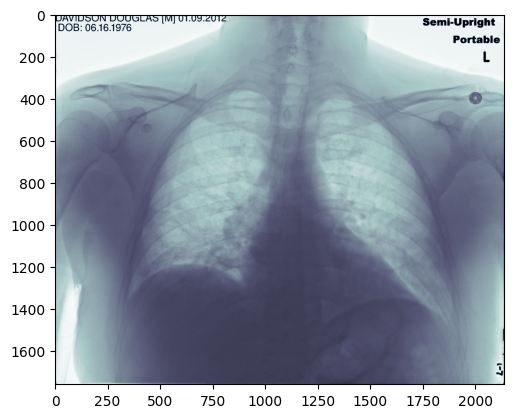

In [188]:
display_dicom(raw_dcm)

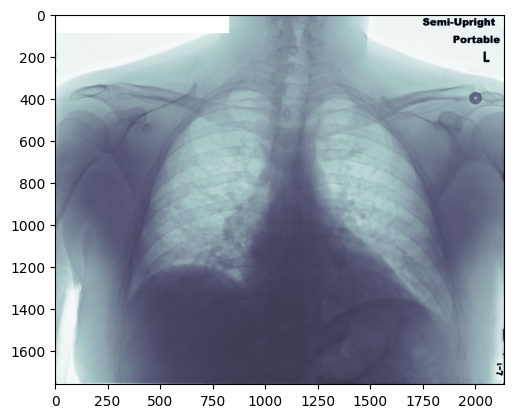

In [189]:
display_dicom(deid_dcm)

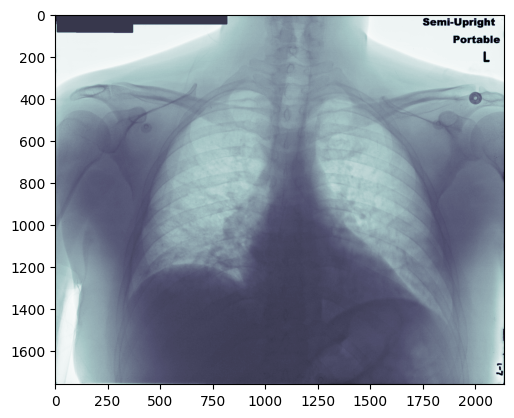

In [190]:
display_dicom(deidentfied_dcm)

In [191]:
# tagvalues = []
# for element in raw_dcm:
#     if element.VR == 'OW':
#         print(element.name)
#         continue
#     deidval = "Not available"
#     if element.tag in deid_dcm:
#         deidval = str(deid_dcm[element.tag].value)
#     dcmannonval = "Not available"
#     if element.tag in deidentfied_dcm:
#         dcmannonval = str(deidentfied_dcm[element.tag].value)
#     changed = False
#     if str(element.value) != deidval:
#         changed = True
#     values_tuple = (str(element.tag), element.name, str(element.value), deidval, dcmannonval, changed)
#     tagvalues.append(values_tuple)

In [192]:
import pydicom

In [193]:
tagvalues = []
    
def extract_tags(dcm, gt_ds, annon_ds):
    elements = dcm
    gt_elements = gt_ds
    annon_elements = annon_ds
    parent_tag = None
    
    if isinstance(dcm, pydicom.dataelem.DataElement):
        parent_tag = dcm.tag
        elements = dcm.value[0]
        gt_elements = gt_ds.value[0] if gt_ds else None
        annon_elements = annon_ds.value[0] if annon_ds else None
        
    for element in elements:
        deidelem = gt_elements.get(element.tag) if gt_elements else None
        dcmannonelem = annon_elements.get(element.tag) if annon_elements else None
        
        if element.VR == 'OW':
            continue
        elif element.VR == 'SQ':
            extract_tags(element, deidelem, dcmannonelem)
            continue
        targettags.append(element.tag)
        
        deidval = "Not available"
        if deidelem:
            deidval = str(deidelem.value)
        dcmannonval = "Not available"
        if dcmannonelem:
            dcmannonval = str(dcmannonelem.value)
        changed = False
        if str(element.value) != deidval:
            changed = True

        element_tag_str = str(element.tag)
        if parent_tag:
            element_tag_str = f"{str(parent_tag)} - {str(element.tag)}"
        values_tuple = (element_tag_str, element.VR, element.name, str(element.value), deidval, dcmannonval, changed)
        tagvalues.append(values_tuple)

extract_tags(raw_dcm, deid_dcm, deidentfied_dcm)

In [194]:
valus_df = pd.DataFrame(tagvalues, columns =['Tag', 'VR', 'Name', 'Raw Metadata', 'Ground Truth Anonimization', 'PS 3.3 Anonymizer', 'Changed'])

In [195]:
changed_df = valus_df[valus_df['Changed']]
changed_df

,Tag,VR,Name,Raw Metadata,Ground Truth Anonimization,PS 3.3 Anonymizer,Changed
2,"(0008, 0018)",UI,SOP Instance UID,2.25.112784503178059210578740147414000844278,1.3.6.1.4.1.14519.5.2.1.8700.9668.265811167095...,1.2.826.0.1.3680043.8.498.22161320228547893506...,True
3,"(0008, 0020)",DA,Study Date,20130713,20030626,20131110,True
4,"(0008, 0021)",DA,Series Date,20130713,20030626,20131110,True
5,"(0008, 0022)",DA,Acquisition Date,20130713,20030626,20131110,True
6,"(0008, 0023)",DA,Content Date,20130713,20030626,20131110,True
11,"(0008, 0050)",SH,Accession Number,20130714E864535,,,True
14,"(0008, 0080)",LO,Institution Name,Scott Community Hospital,Not available,,True
15,"(0008, 0081)",ST,Institution Address,"334 Michael Manor Sarahview, PA 56560",Not available,Not available,True
16,"(0008, 0090)",PN,Referring Physician's Name,HUGHES^KATHLEEN,,,True
17,"(0008, 0092)",ST,Referring Physician's Address,"0544 Green Inlet Jeffreyland, HI 66060",Not available,Not available,True


In [196]:
n_mismatched = 0
mismatched_tags = []

for index, row in changed_df.iterrows():
    gt_val = row['Ground Truth Anonimization']
    target_val = row['PS 3.3 Anonymizer']

    if gt_val != target_val:
        if row['VR'] in ('UI', 'DA', 'DT') and not (gt_val == "" or target_val == ""):
            continue
        elif row['Tag'] in ('(0010, 0010)', '(0010, 0020)'):
            continue
        n_mismatched += 1
        mismatched_tags.append(row['Name'])

print(n_mismatched)
print(mismatched_tags)

3
['Institution Name', 'Study Description', "Patient's Birth Date"]
